# parkrun Kraków 5k 20/05/2023 | #461

## Overview | Motivation

A couple of weeks ago I signed up for [parkrun Kraków]('https://www.parkrun.pl/krakow'). I had a dry run on 6 May, just to see how it all worked. There was a bit of a mix up with the scanning and my 'official' time was a bit artificial, but on Saturday I took part in my first proper parkrun.

It turns out it was the 10 year anniversary of the event in Kraków, and there was a great atmosphere, and quite a few more runners than on my dry run!

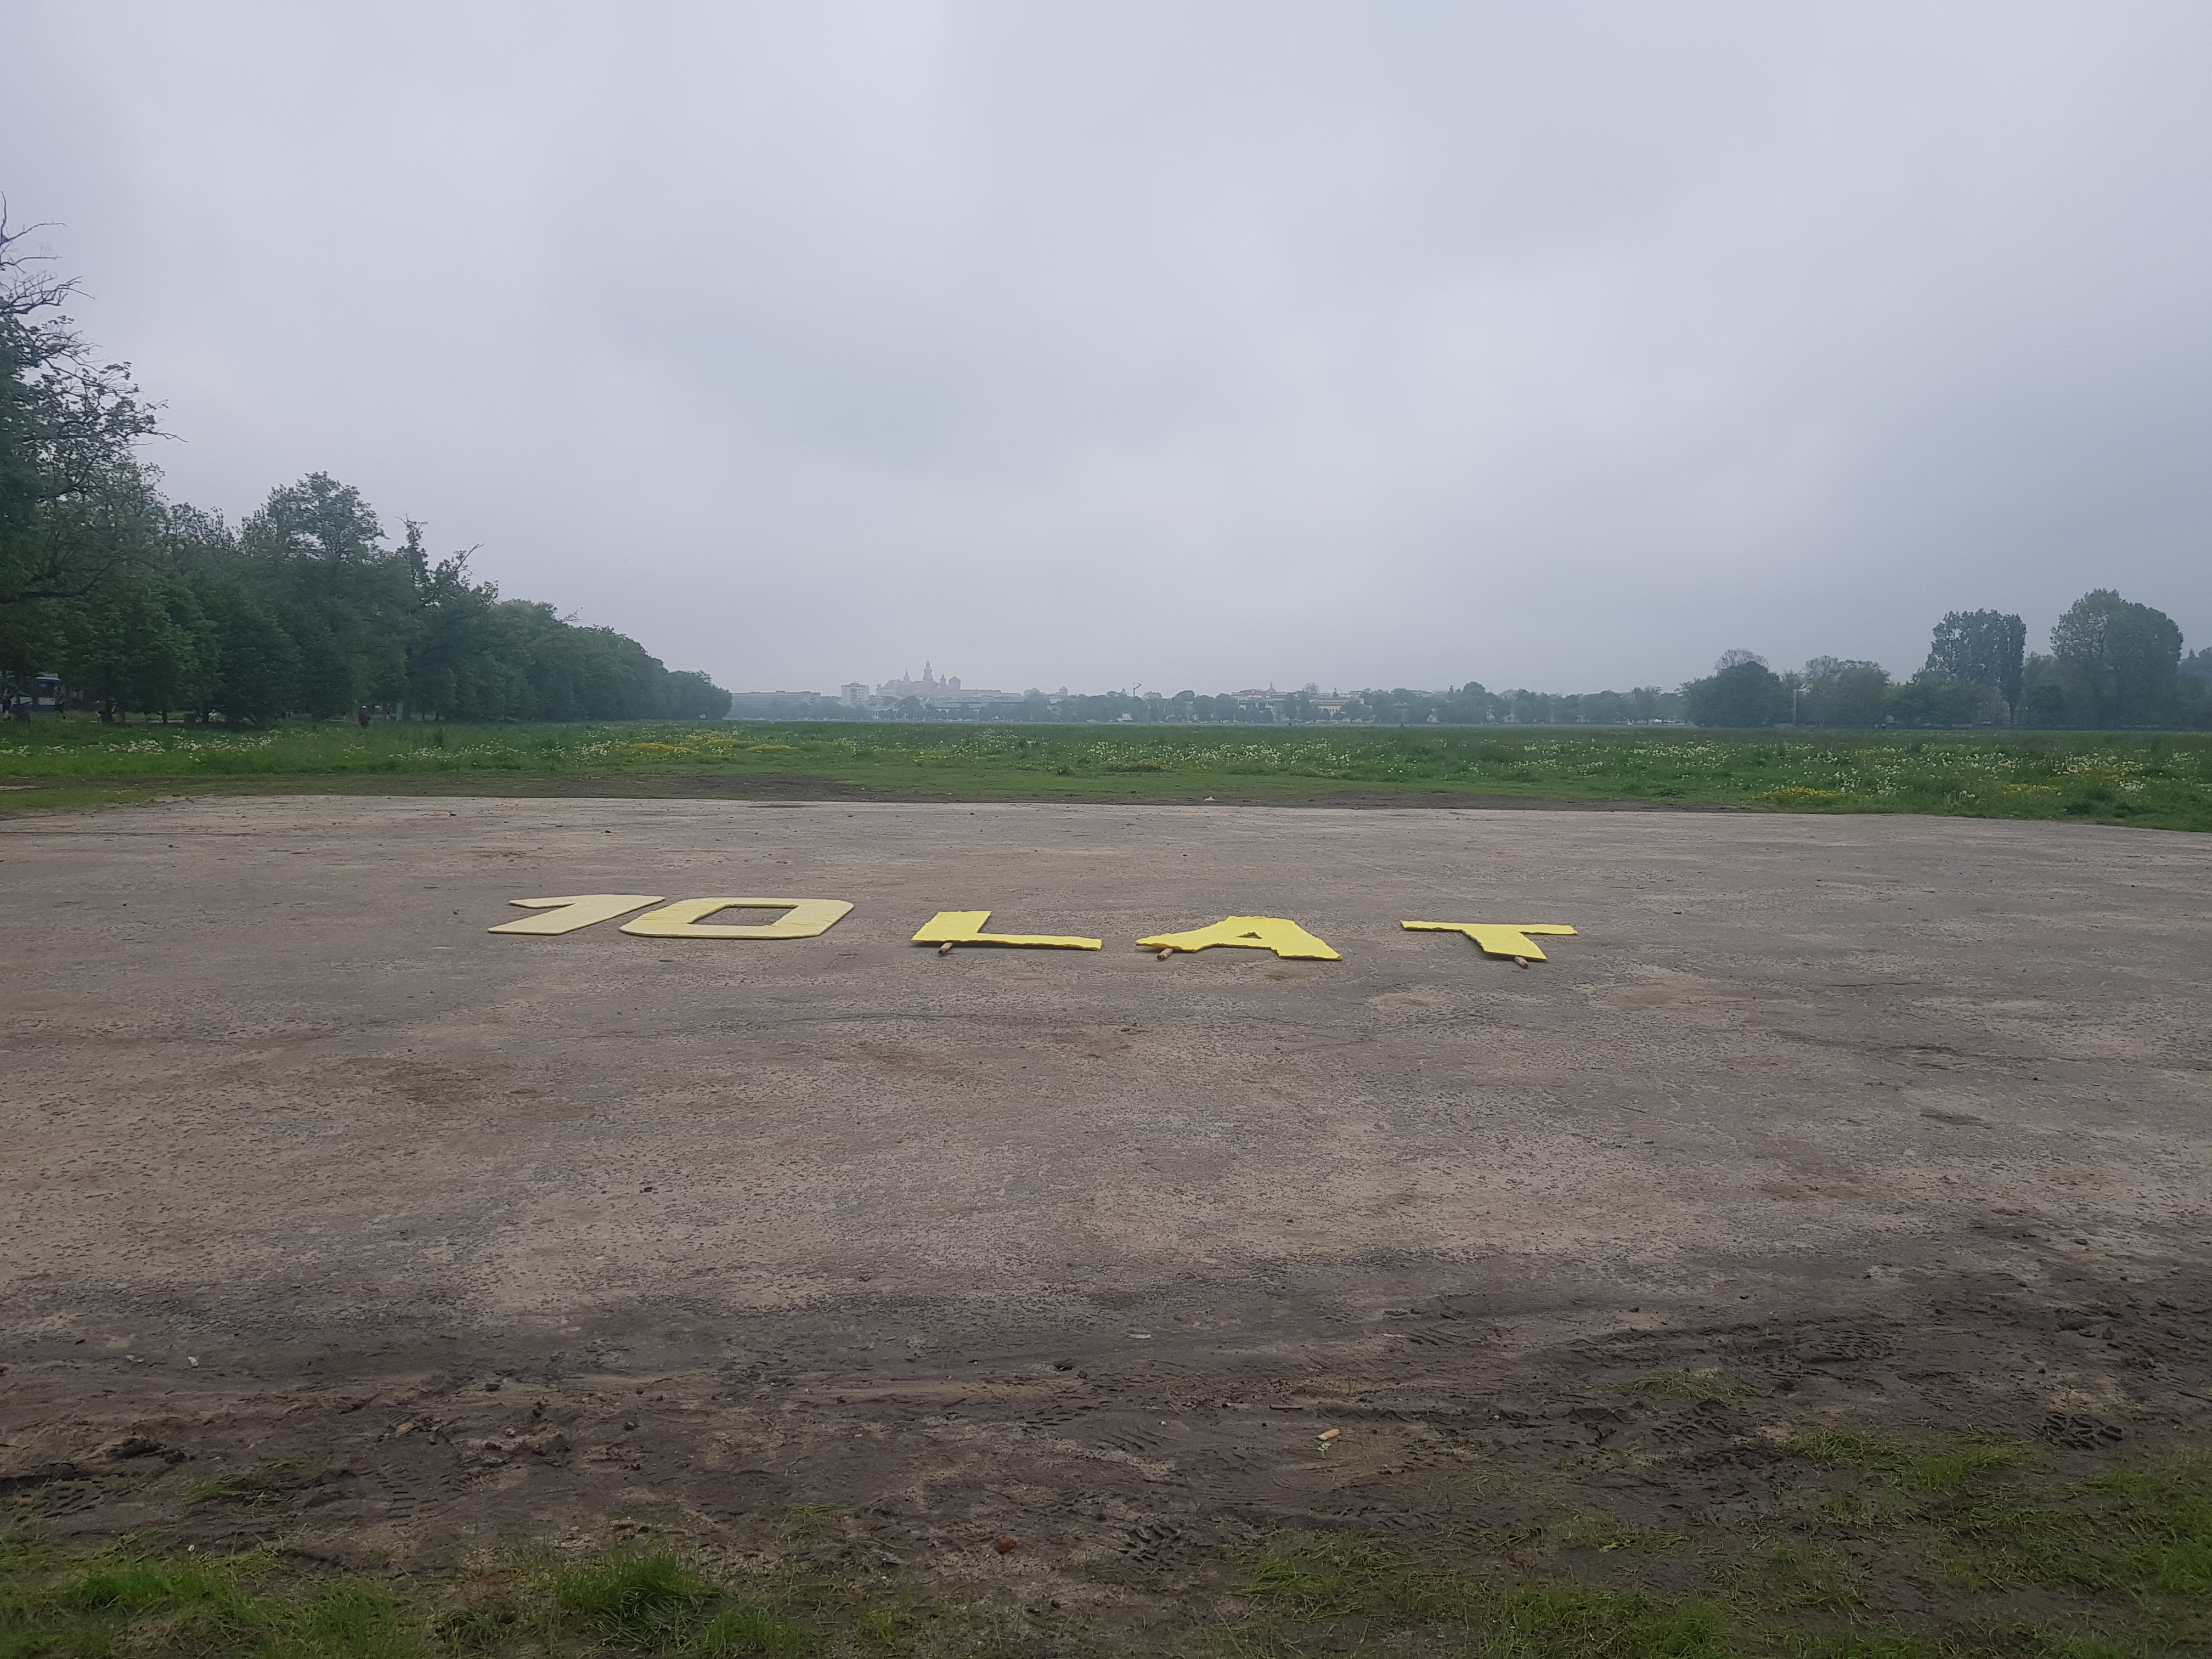

After the race I thought it would be fun to do a bit of a data dive on this race. My aim was to gain an insight into the distribution of competitors across age and sex, and I was particularly interested in discovering whether being affiliated with a running club results in a faster race time (as you might expect) compared to unattached runners like me.

### Data source

The results are published each week on the [official website](https://www.parkrun.pl/krakow/results/latestresults/). I could not find an API and so I just copied and pasted form the table into a csv file for cleansing using [pandas](https://pandas.pydata.org/), and visualisation using [Seaborn](https://seaborn.pydata.org/).

It turns out that there was a lot more cleaning required than I first thought! Often the case with smaller datasets. 

### Import the required packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Load in the data 

In [2]:
parkrun_krakow_20_05_23 = pd.read_csv('krakow_20_05_23.csv', encoding='latin')

### Exploratory Data Analysis | Cleansing

In [3]:
# Drop name column for anonymity
parkrun_krakow_20_05_23 = parkrun_krakow_20_05_23.drop('UCZESTNIK', axis=1)

# preview our data
parkrun_krakow_20_05_23

POZYCJA       P?E? KATEGORIA WIEKOWA                    KLUB      CZAS
0          1  M??czyzna           VM35-39                     NaN     16:29
1          2  M??czyzna           VM40-44     #AdamCzerwi?skiTeam     17:33
2          3        NaN               NaN                     NaN       NaN
3          4  M??czyzna           VM35-39            ITMBW Kraków     17:56
4          5  M??czyzna           VM35-39            Wawel Kraków     18:07
..       ...        ...               ...                     ...       ...
350      351  M??czyzna           VM45-49                     NaN  51:30:00
351      352  M??czyzna           VM90-94                     NaN  54:54:00
352      353    Kobieta           VW60-64  Biegam bo lubie Gdynia  54:55:00
353      354    Kobieta           VW50-54            #YOLOTEAMKRK  54:55:00
354      355  M??czyzna           VM75-79                     NaN  54:55:00

[355 rows x 5 columns]

Let's rename the columns, which are in Polish at the moment. We can see that we also have some problems with Polish letters not being recognised. We'll deal with this also.

In [4]:
# Rename columns
parkrun_krakow_20_05_23 = parkrun_krakow_20_05_23.rename(columns={'POZYCJA': 'Position', '': 'Name', 'P?E?': 'Sex','KATEGORIA WIEKOWA': 'Age_Group','KLUB': 'Club_Runner?', 'CZAS': 'Time'})


In [5]:
parkrun_krakow_20_05_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Position      355 non-null    int64 
 1   Sex           333 non-null    object
 2   Age_Group     333 non-null    object
 3   Club_Runner?  115 non-null    object
 4   Time          333 non-null    object
dtypes: int64(1), object(4)
memory usage: 14.0+ KB


We can see that although there are 355 observations for 'Position', we only have 333 observations for 'Time'. It often happens that runners participate who have not officially signed up and so although their position is logged, no further details are available. 

### NaN values

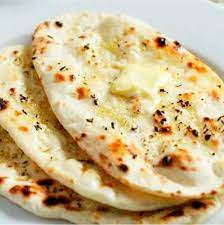

In [6]:
parkrun_krakow_20_05_23.isna().sum()

Position          0
Sex              22
Age_Group        22
Club_Runner?    240
Time             22
dtype: int64

As anticipated we have 22 `NaN` values for `Sex`, `Age_Group` and `Time`. So let's remove all observations where no race time was recorded :

In [7]:
parkrun_krakow_20_05_23 = parkrun_krakow_20_05_23.dropna(subset=['Time'])

And check our NaNs again :

In [8]:
parkrun_krakow_20_05_23.isna().sum()

Position          0
Sex               0
Age_Group         0
Club_Runner?    218
Time              0
dtype: int64

We still have to deal with the `Club_Runner` discrepancies. A value is only included if a runner is affiliated to a running club. Non-affiliated runners are treated as `NaN`. Let's replace non-affiliated with `No` and affiliated with `Yes` :

In [9]:
# Replace values based on conditions
parkrun_krakow_20_05_23['Club_Runner?'].fillna('No', inplace=True)
parkrun_krakow_20_05_23['Club_Runner?'] = np.where(parkrun_krakow_20_05_23['Club_Runner?'] != 'No', 'Yes', 'No')

In [10]:
parkrun_krakow_20_05_23.isna().sum()

Position        0
Sex             0
Age_Group       0
Club_Runner?    0
Time            0
dtype: int64

Excellent. We have cleaned up all `NaN` values. Let's have a look at our datatypes :

### Datatypes

In [11]:
parkrun_krakow_20_05_23.dtypes

Position         int64
Sex             object
Age_Group       object
Club_Runner?    object
Time            object
dtype: object

We have a problem here. Our race times are an 'object'. We will need to convert this. Let's create a new column `Time_mins` :

### Time

In [12]:
# Split the string into minutes and seconds components
time_components = parkrun_krakow_20_05_23['Time'].str.split(':')

# Convert the minutes and seconds components to integers
minutes = time_components.str[0].astype(int)
seconds = time_components.str[1].astype(int)

# Calculate the decimal representation of minutes
parkrun_krakow_20_05_23['Time_mins'] = minutes + seconds / 60.0

# Round the "minutes" column to 2 decimal places
parkrun_krakow_20_05_23['Time_mins'] = parkrun_krakow_20_05_23['Time_mins'].round(2)

# Output the result
print(parkrun_krakow_20_05_23['Time_mins'])

0      16.48
1      17.55
3      17.93
4      18.12
5      18.35
       ...  
350    51.50
351    54.90
352    54.92
353    54.92
354    54.92
Name: Time_mins, Length: 333, dtype: float64


We now have race times as `float` that is in minutes (rounded to 2 decimal places).

### Categorical variables

In [13]:
parkrun_krakow_20_05_23.nunique()

Position        333
Sex               2
Age_Group        29
Club_Runner?      2
Time            311
Time_mins       311
dtype: int64

Ok, so we have :
    
- 311 unique times, so quite a few crossing the line together
- 2 different sexes - M (Male) and F (Female)
- 29 different age groups
- 2 distinct values for Club_Runner (Yes or No - as defined earlier)

### Cosmetic changes

Let's do some general tidy up. We can use string slicing to remove leading characters in the `Age_Group` column :

In [14]:
# Remove the first two characters from the strings in the "Age_Group" column
parkrun_krakow_20_05_23['Age_Group']=parkrun_krakow_20_05_23['Age_Group'].str[2:]

Let's also tidy up the narrative in the `Sex` column, by replacing `Mezczyzna` with `M` and `Kobieta` with `F` :

In [15]:
# Replace strings starting with 'M' to 'M' in the "Sex" column
parkrun_krakow_20_05_23.loc[parkrun_krakow_20_05_23['Sex'].str.startswith('M'), 'Sex'] = 'M'

# Replace strings starting with 'K' to 'F' in the "Sex" column
parkrun_krakow_20_05_23.loc[parkrun_krakow_20_05_23['Sex'].str.startswith('K'), 'Sex'] = 'F'

In [16]:
parkrun_krakow_20_05_23

Position Sex Age_Group Club_Runner?      Time  Time_mins
0           1   M     35-39           No     16:29      16.48
1           2   M     40-44          Yes     17:33      17.55
3           4   M     35-39          Yes     17:56      17.93
4           5   M     35-39          Yes     18:07      18.12
5           6   M     40-44          Yes     18:21      18.35
..        ...  ..       ...          ...       ...        ...
350       351   M     45-49           No  51:30:00      51.50
351       352   M     90-94           No  54:54:00      54.90
352       353   F     60-64          Yes  54:55:00      54.92
353       354   F     50-54          Yes  54:55:00      54.92
354       355   M     75-79           No  54:55:00      54.92

[333 rows x 6 columns]

Looking much tidier. Let's now return to the `Age Groupings`. These are currently a categorical variable, but let's simplify things by creating a new column `Age_Midpoint` that splits the string, converts to integer, and takes the mid-value of the range : 

In [17]:
# Define conversion function
def get_age_midpoint(age_group):
    if '-' in age_group:
        age_range = age_group.split('-')
        age_start = int(age_range[0])
        age_end = int(age_range[1])
        age_midpoint = (age_start + age_end) // 2
    else:
        age_midpoint = int(age_group)
    return age_midpoint    

In [18]:
# Apply the conversion function to the Age_Group column
parkrun_krakow_20_05_23['Age_Midpoint'] = parkrun_krakow_20_05_23['Age_Group'].apply(get_age_midpoint)

In [19]:
parkrun_krakow_20_05_23

Position Sex Age_Group Club_Runner?      Time  Time_mins  Age_Midpoint
0           1   M     35-39           No     16:29      16.48            37
1           2   M     40-44          Yes     17:33      17.55            42
3           4   M     35-39          Yes     17:56      17.93            37
4           5   M     35-39          Yes     18:07      18.12            37
5           6   M     40-44          Yes     18:21      18.35            42
..        ...  ..       ...          ...       ...        ...           ...
350       351   M     45-49           No  51:30:00      51.50            47
351       352   M     90-94           No  54:54:00      54.90            92
352       353   F     60-64          Yes  54:55:00      54.92            62
353       354   F     50-54          Yes  54:55:00      54.92            52
354       355   M     75-79           No  54:55:00      54.92            77

[333 rows x 7 columns]

Great, we now have our new column with a single integer value. Our cleaning is now complete. 

### Retrieve my race time

Overall, I was quite pleased with my time. I had a target of 25 minutes in mind which I beat - by 3 seconds! 

In [20]:
# Names have been removed for anonymity but I know I finished in position 131, so index 130
my_row = parkrun_krakow_20_05_23.loc[130]
my_race_time = my_row['Time_mins']
my_race_time

24.95

### Visualizations

### Scatterplot of all race times across age groupings and by sex

Scatterplots are an excellent visualization, and we can even introduce a third variable (Sex) by the use of colour. It allows us to see at a glance the age and sex profile of all race times. 

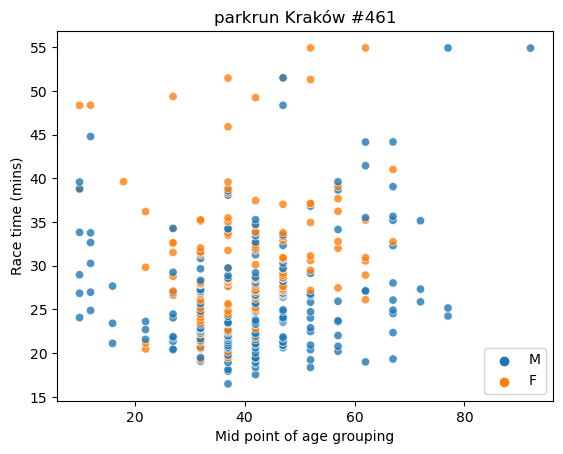

In [21]:
# Use the 'hue' argument to provide a factor variable
sns.scatterplot(x="Age_Midpoint", y="Time_mins", data=parkrun_krakow_20_05_23, hue='Sex', alpha=0.8)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.title ('parkrun Kraków #461')
plt.xlabel ('Mid point of age grouping')
plt.ylabel ('Race time (mins)')

plt.show()

We can see that the fastest race time recorded was by a male around the age of 37 or so, and there is a general concentration of male runners aged 37 to 57 recording race times of 25 minutes or less. 

### Scatterplot of all race times across age groupings and by running club affiliation

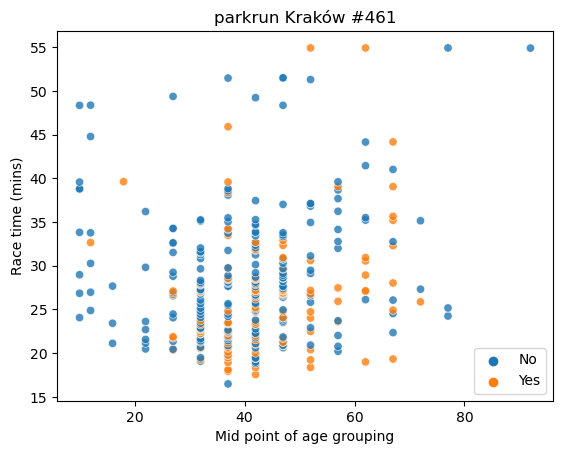

In [22]:
# Use the 'hue' argument to provide a factor variable
sns.scatterplot(x="Age_Midpoint", y="Time_mins", data=parkrun_krakow_20_05_23, hue='Club_Runner?', alpha=0.8)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.title ('parkrun Kraków #461')
plt.xlabel ('Mid point of age grouping')
plt.ylabel ('Race time (mins)')

plt.show()

We can see that the fastest race time recorded by someone around the age of 37 or so who is not affiliated with a running club. 
The times recorded for club runners generally appear to be lower, with only three over 45 minutes, compared with 10 for non-attached runners.

### Boxplots of race times across age groupings and by sex

A box plot, also known as a box-and-whisker plot, is a graphical representation that summarizes the distribution of a dataset. It displays key statistical measures, including the minimum, maximum, median, and quartiles.

The box in the plot represents the interquartile range (IQR), which is the range between the first quartile (Q1) and the third quartile (Q3). The median is represented by a line or a dot within the box.

Whiskers extend from the box and indicate the minimum and maximum values within a certain range, typically defined by a multiple of the IQR. Values outside this range are considered outliers and can be plotted as individual points or asterisks.

Box plots are useful for comparing distributions, identifying skewness or symmetry, detecting outliers, and understanding the spread and central tendency of the data. They provide a concise visual summary of the dataset's main characteristics.

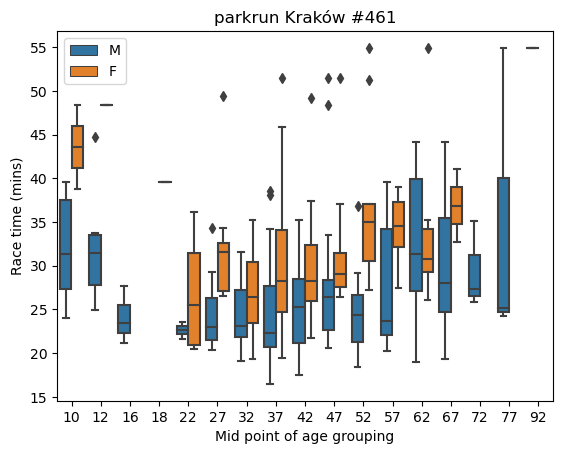

In [23]:
# create box plots of run time per age group
# use hue to allow comparison between male and female
sns.boxplot(x = 'Age_Midpoint',
            y = 'Time_mins', 
            data = parkrun_krakow_20_05_23, 
            hue = 'Sex')

# Sometimes the labelling can get a bit cluttered. We can control this
# loc=0 moves legend to the best position
plt.legend(loc=0)

plt.title ('parkrun Kraków #461')
plt.xlabel ('Mid point of age grouping')
plt.ylabel ('Race time (mins)')

plt.show()

We can see from the above that for all age categories (with the exception of age 62) median race times (as denoted by the line within the box) for males are lower. We can also see that there is a wide range of times in the female age 37 category (from a low of around 25 minutes to a high of around 47 minutes) and also in the male age categories, 62, 67, and 77.

### Boxplots of race times across age groupings and by running club affiliation

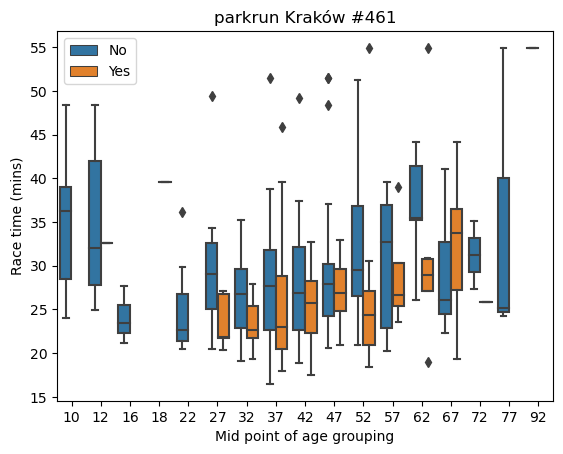

In [24]:
# create box plots of run time per age group
# use hue to allow comparison between male and female
sns.boxplot(x = 'Age_Midpoint',
            y = 'Time_mins', 
            data = parkrun_krakow_20_05_23, 
            hue = 'Club_Runner?')

# Sometimes the labelling can get a bit cluttered. We can control this
# loc=0 moves legend to the best position
plt.legend(loc=0)

plt.title ('parkrun Kraków #461')
plt.xlabel ('Mid point of age grouping')
plt.ylabel ('Race time (mins)')

plt.show()

We can see at a glance that whilst the lowest time was recorded by a non-club runner, generally the race times for club runners are less stretched out. They mostly fall within the 20 to 35 minutes range.

### Number of runners

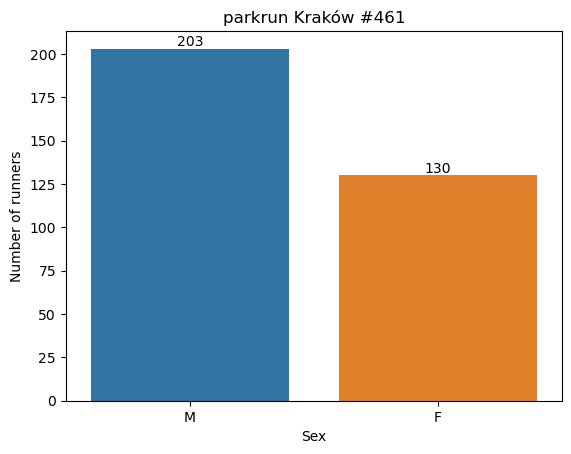

In [25]:
# plot a count of number of males and females
ax = sns.countplot(x = 'Sex',
              data = parkrun_krakow_20_05_23)

plt.title ('parkrun Kraków #461')
plt.xlabel ('Sex')
plt.ylabel ('Number of runners')

# Add count values on top of each bar
for p in ax.patches:
    count = p.get_height()
    ax.annotate(f'{round(count)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

Males represented 61% of the race entries.

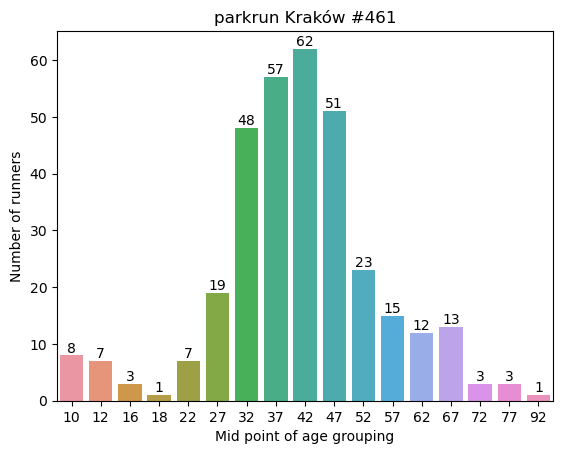

In [26]:
# plot a count of number of runners in each Age Grouping
ax = sns.countplot(x = 'Age_Midpoint',
              data = parkrun_krakow_20_05_23)

plt.title ('parkrun Kraków #461')
plt.xlabel ('Mid point of age grouping')
plt.ylabel ('Number of runners')

# Add rounded count values on top of each bar (rounded to 2 decimal places)
for p in ax.patches:
    count = p.get_height()
    ax.annotate(f'{count:.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

We can see a high concentration of runners (65%) fall within the 32 to 47 midpoint age.

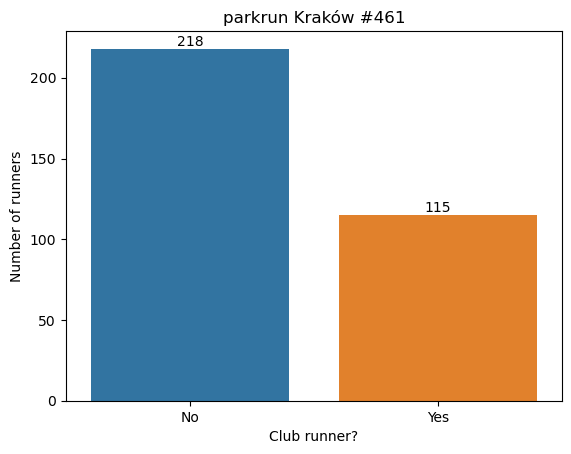

In [27]:
# plot a count of number of club runners vs unattached
ax = sns.countplot(x = 'Club_Runner?',
              data = parkrun_krakow_20_05_23)

plt.title ('parkrun Kraków #461')
plt.xlabel ('Club runner?')
plt.ylabel ('Number of runners')

# Add count values on top of each bar
for p in ax.patches:
    count = p.get_height()
    ax.annotate(f'{round(count)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

The majority (65%) of runners are not affiliated with any running club. 

### Median race times

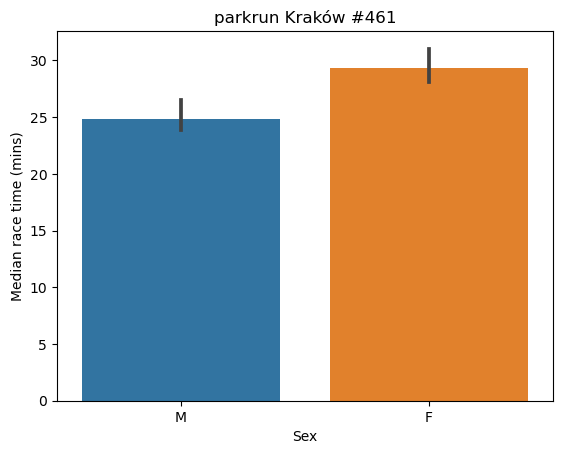

In [28]:
# plot a barplot showing median race time by sex
sns.barplot(x = 'Sex', 
            y = 'Time_mins', 
            data = parkrun_krakow_20_05_23,
           estimator = np.median) 

plt.title ('parkrun Kraków #461')
plt.xlabel ('Sex')
plt.ylabel ('Median race time (mins)')

plt.show()

The median race time for males was just under 25 minutes, and for females it was just under 30 minutes.

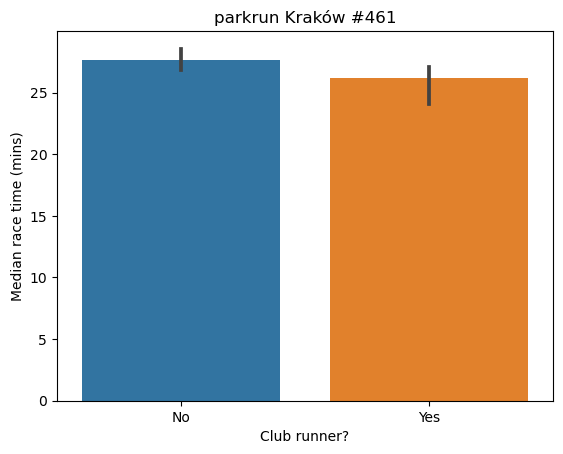

In [29]:
# plot a barplot showing median race time by running club membership
sns.barplot(x = 'Club_Runner?', 
            y = 'Time_mins', 
            data = parkrun_krakow_20_05_23,
           estimator = np.median) 

plt.title ('parkrun Kraków #461')
plt.xlabel ('Club runner?')
plt.ylabel ('Median race time (mins)')

plt.show()


As expected, the median race time for club runners was lower than unattached runners.

### Fastest race times across age groupings

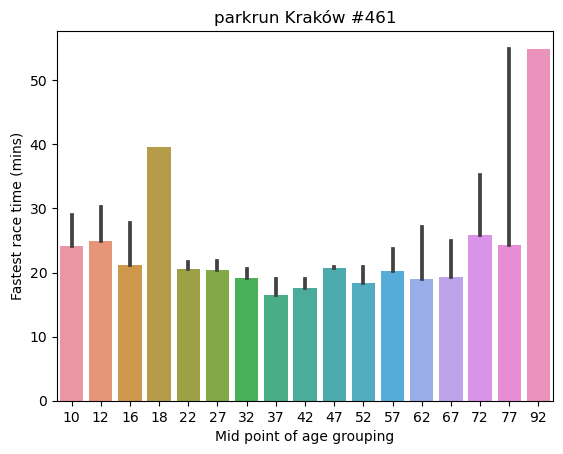

In [30]:
# plot a barplot showing min race time
sns.barplot(x = 'Age_Midpoint', 
            y = 'Time_mins', 
            data = parkrun_krakow_20_05_23,
           estimator = np.min)  

plt.title ('parkrun Kraków #461')
plt.xlabel ('Mid point of age grouping')
plt.ylabel ('Fastest race time (mins)')

plt.show()

The fastest race times are concentrated in the 22 to 52 age range, although there are some excellent times recorded in the 67 age group, before Father Time joins the party!

### Workings

In [31]:
number_of_runners = parkrun_krakow_20_05_23['Position'].count()

In [32]:
fastest_race_time = parkrun_krakow_20_05_23['Time_mins'].min()

In [33]:
median_race_time = parkrun_krakow_20_05_23['Time_mins'].median()

In [34]:
group_by_sex = parkrun_krakow_20_05_23.groupby(['Sex'])

In [35]:
group_by_sex['Time_mins'].min()

Sex
F    19.28
M    16.48
Name: Time_mins, dtype: float64

In [36]:
fastest_female = group_by_sex['Time_mins'].min()[0]
fastest_female

19.28

In [37]:
fastest_male = group_by_sex['Time_mins'].min()[1]
fastest_male

16.48

In [38]:
group_by_sex['Time_mins'].median()

Sex
F    29.305
M    24.830
Name: Time_mins, dtype: float64

In [39]:
median_female_time = group_by_sex['Time_mins'].median()[0]
median_female_time

29.305

In [40]:
median_male_time = group_by_sex['Time_mins'].median()[1]
median_male_time

24.83

In [41]:
group_by_club = parkrun_krakow_20_05_23.groupby(['Club_Runner?'])

In [42]:
group_by_club['Time_mins'].min()

Club_Runner?
No     16.48
Yes    17.55
Name: Time_mins, dtype: float64

In [43]:
fastest_club = group_by_club['Time_mins'].min()[1]
fastest_club

17.55

In [44]:
median_club = group_by_club['Time_mins'].median()[1]
median_club

26.2

In [45]:
fastest_unattached = group_by_club['Time_mins'].min()[0]
fastest_unattached

16.48

In [46]:
median_unattached = group_by_club['Time_mins'].median()[0]
median_unattached

27.66

In [47]:
fastest_time_my_sex_age_group = parkrun_krakow_20_05_23[(parkrun_krakow_20_05_23['Age_Midpoint'] == 47) & (parkrun_krakow_20_05_23['Sex'] == 'M')]['Time_mins'].min()
fastest_time_my_sex_age_group

20.63

In [48]:
median_time_my_sex_age_group = parkrun_krakow_20_05_23[(parkrun_krakow_20_05_23['Age_Midpoint'] == 47) & (parkrun_krakow_20_05_23['Sex'] == 'M')]['Time_mins'].median()
median_time_my_sex_age_group 

26.43

### Results Summary

In [49]:
print(f'Number of runners: {number_of_runners}')
print(f'My race time (mins): {my_race_time:.2f}')
print(f'Fastest race time for my sex and age group (mins):{fastest_time_my_sex_age_group:.2f}')
print(f'Median race time for my sex and age group (mins): {median_time_my_sex_age_group:.2f}')
print(f'Fastest race time (mins): {fastest_race_time:.2f}')
print(f'Median race time (mins): {median_race_time:.2f}')
print(f'Fastest male race time (mins): {fastest_male:.2f}')
print(f'Median male race time (mins): {median_male_time:.2f}')
print(f'Fastest female race time (mins): {fastest_female:.2f}')
print(f'Median female race time (mins): {median_female_time:.2f}')
print(f'Fastest affiliated race time (mins): {fastest_club:.2f}')
print(f'Median affiliated race time (mins): {median_club:.2f}')
print(f'Fastest non-affiliated race time (mins): {fastest_unattached:.2f}')
print(f'Median non-affiliated race time (mins): {median_unattached:.2f}')

Number of runners: 333
My race time (mins): 24.95
Fastest race time for my sex and age group (mins):20.63
Median race time for my sex and age group (mins): 26.43
Fastest race time (mins): 16.48
Median race time (mins): 27.08
Fastest male race time (mins): 16.48
Median male race time (mins): 24.83
Fastest female race time (mins): 19.28
Median female race time (mins): 29.30
Fastest affiliated race time (mins): 17.55
Median affiliated race time (mins): 26.20
Fastest non-affiliated race time (mins): 16.48
Median non-affiliated race time (mins): 27.66


### Customized functions

I worked through the cleansing as I was going along to demonstrate the concepts involved, however it is quite clumsy and scattered around. A better way would be to introduce some structure and create a customized function that will allow me to quickly pre-process any future race results using the same methodology.

Note, that this could be improved further by harnessing a workflow orchestration tool such as [Prefect](https://www.prefect.io/) and creating an ingestion script that takes the raw data, preprocesses it, and moves into bucket storage on [Google Cloud Platform(GCP)](https://cloud.google.com/gcp?&gad=1) for further querying in BigData, and visualization using e.g [Looker Studio](https://lookerstudio.google.com/).

In [50]:
# Convert age grouping to mid-point
def get_age_midpoint(age_group):
    if '-' in age_group:
        age_range = age_group.split('-')
        age_start = int(age_range[0])
        age_end = int(age_range[1])
        age_midpoint = (age_start + age_end) // 2
    else:
        age_midpoint = int(age_group)
    return age_midpoint 

In [51]:
import pandas as pd
import numpy as np

def process_race_results(race_date):
    
    # Step 1: Read the CSV file
    filename = f"krakow_{race_date}"
    df = pd.read_csv(f"{filename}.csv", encoding='latin')
        
    # Step 2: Drop the 'UCZESTNIK' column
    df = df.drop(columns=['UCZESTNIK'])

    # Step 3: Rename the columns
    df = df.rename(columns={'POZYCJA': 'Position', '': 'Name', 'P?E?': 'Sex', 'KATEGORIA WIEKOWA': 'Age_Group',
                            'KLUB': 'Club_Runner?', 'CZAS': 'Time'})

    # Step 4: Drop rows with 'NaN' in 'Time' column
    df = df.dropna(subset=['Time'])

    # Step 5: Replace 'NaN' values in 'Club_Runner?' column with 'No'
    df['Club_Runner?'].fillna('No', inplace=True)
    df['Club_Runner?'] = np.where(df['Club_Runner?'] != 'No', 'Yes', 'No')

    # Step 6: Convert 'Time' values from string to float, rounded to 2 decimal places
    # Split the string into minutes and seconds components
    time_components = df['Time'].str.split(':')
    # Convert the minutes and seconds components to integers
    minutes = time_components.str[0].astype(int)
    seconds = time_components.str[1].astype(int)
    # Calculate the decimal representation of minutes
    df['Time_mins'] = minutes + seconds / 60.0
    # Round the "minutes" column to 2 decimal places
    df['Time_mins'] = df['Time_mins'].round(2)
    
    # Step 7: Remove leading two characters from 'Age_Group' column
    df['Age_Group'] = df['Age_Group'].str[2:]

    # Step 8: Replace values in 'Sex' column with 'M' or 'F' based on the starting character
    df['Sex'] = df['Sex'].apply(lambda x: 'M' if x.startswith('M') else 'F')

    # Step 9: Convert 'Age_Group' values in the format '35-39' to the mid-point of the range
    # Apply the conversion function to the Age_Group column
    df['Age_Midpoint'] = df['Age_Group'].apply(get_age_midpoint)
        
    # GroupBys for Headline figures
    number_of_runners = parkrun_krakow_20_05_23['Position'].count()
    fastest_race_time = parkrun_krakow_20_05_23['Time_mins'].min()
    fastest_time_my_sex_age_group = parkrun_krakow_20_05_23[(parkrun_krakow_20_05_23['Age_Midpoint'] == 47) & (parkrun_krakow_20_05_23['Sex'] == 'M')]['Time_mins'].min()
    median_time_my_sex_age_group = parkrun_krakow_20_05_23[(parkrun_krakow_20_05_23['Age_Midpoint'] == 47) & (parkrun_krakow_20_05_23['Sex'] == 'M')]['Time_mins'].median()
    fastest_race_time = parkrun_krakow_20_05_23['Time_mins'].min()
    median_race_time = parkrun_krakow_20_05_23['Time_mins'].median()
    fastest_male = group_by_sex['Time_mins'].min()[1]
    median_male_time = group_by_sex['Time_mins'].median()[1]
    fastest_female = group_by_sex['Time_mins'].min()[0]
    median_female_time = group_by_sex['Time_mins'].median()[0]
    fastest_club = group_by_club['Time_mins'].min()[1]
    median_club = group_by_club['Time_mins'].median()[1]
    fastest_unattached = group_by_club['Time_mins'].min()[0]
    median_unattached = group_by_club['Time_mins'].median()[0]
    
    # Headline figures
    print(f'Number of runners: {number_of_runners}')
    print(f'Fastest race time for my sex and age group (mins):{fastest_time_my_sex_age_group:.2f}')
    print(f'Median race time for my sex and age group (mins): {median_time_my_sex_age_group:.2f}')
    print(f'Fastest race time (mins): {fastest_race_time:.2f}')
    print(f'Median race time (mins): {median_race_time:.2f}')
    print(f'Fastest male race time (mins): {fastest_male:.2f}')
    print(f'Median male race time (mins): {median_male_time:.2f}')
    print(f'Fastest female race time (mins): {fastest_female:.2f}')
    print(f'Median female race time (mins): {median_female_time:.2f}')
    print(f'Fastest affiliated race time (mins): {fastest_club:.2f}')
    print(f'Median affiliated race time (mins): {median_club:.2f}')
    print(f'Fastest non-affiliated race time (mins): {fastest_unattached:.2f}')
    print(f'Median non-affiliated race time (mins): {median_unattached:.2f}')
    
    return df

I now just need to pass in the following arguments to the pre-processing function to achieve the same results as before:

In [52]:
race_date = '20_05_23'
processed_results = process_race_results(race_date)
processed_results

Number of runners: 333
Fastest race time for my sex and age group (mins):20.63
Median race time for my sex and age group (mins): 26.43
Fastest race time (mins): 16.48
Median race time (mins): 27.08
Fastest male race time (mins): 16.48
Median male race time (mins): 24.83
Fastest female race time (mins): 19.28
Median female race time (mins): 29.30
Fastest affiliated race time (mins): 17.55
Median affiliated race time (mins): 26.20
Fastest non-affiliated race time (mins): 16.48
Median non-affiliated race time (mins): 27.66


Position Sex Age_Group Club_Runner?      Time  Time_mins  Age_Midpoint
0           1   M     35-39           No     16:29      16.48            37
1           2   M     40-44          Yes     17:33      17.55            42
3           4   M     35-39          Yes     17:56      17.93            37
4           5   M     35-39          Yes     18:07      18.12            37
5           6   M     40-44          Yes     18:21      18.35            42
..        ...  ..       ...          ...       ...        ...           ...
350       351   M     45-49           No  51:30:00      51.50            47
351       352   M     90-94           No  54:54:00      54.90            92
352       353   F     60-64          Yes  54:55:00      54.92            62
353       354   F     50-54          Yes  54:55:00      54.92            52
354       355   M     75-79           No  54:55:00      54.92            77

[333 rows x 7 columns]

### Afterthoughts | Testing

As a quick test that my custom function works, out of interest I grabbed the results for the Edinburgh race on the same day. Minor modifications to the pre-processing due the difference in the raw data, headings used etc, but it works :

In [53]:
# Convert age grouping to mid-point
def get_age_midpoint(age_group):
    if '-' in age_group:
        age_range = age_group.split('-')
        age_start = int(age_range[0])
        age_end = int(age_range[1])
        age_midpoint = (age_start + age_end) // 2
    else:
        age_midpoint = int(age_group)
    return age_midpoint 

In [54]:
import pandas as pd
import numpy as np

def process_race_results(city,race_date):
    
    # Step 1: Read the CSV file
    filename = f"{city}_{race_date}"
    df = pd.read_csv(f"{filename}.csv", encoding='latin')
        
    # Step 2: Drop the 'PARKRUNNER' column
    df = df.drop(columns=['PARKRUNNER'])

    # Step 3: Drop rows with 'NaN' in 'Time' column
    df = df.dropna(subset=['TIME'])

    # Step 4: Replace 'NaN' values in 'CLUB' column with 'No'
    df['CLUB'].fillna('No', inplace=True)
    df['CLUB'] = np.where(df['CLUB'] != 'No', 'Yes', 'No')

    # Step 5: Convert 'Time' values from string to float, rounded to 2 decimal places
    # Split the string into minutes and seconds components
    time_components = df['TIME'].str.split(':')
    # Convert the minutes and seconds components to integers
    minutes = time_components.str[0].astype(int)
    seconds = time_components.str[1].astype(int)
    # Calculate the decimal representation of minutes
    df['TIME_MINS'] = minutes + seconds / 60.0
    # Round the "minutes" column to 2 decimal places
    df['TIME_MINS'] = df['TIME_MINS'].round(2)
    
    # Step 6: Remove leading two characters from 'AGE GROUP' column
    df['AGE GROUP'] = df['AGE GROUP'].str[2:]

    # Step 7: Convert 'Age_Group' values in the format '35-39' to the mid-point of the range
    # Apply the conversion function to the Age_Group column
    df['AGE_MIDPOINT'] = df['AGE GROUP'].apply(get_age_midpoint)
        
    # GroupBys etc for Headline figures
    group_by_sex = df.groupby(['GENDER'])
    group_by_club = df.groupby(['CLUB'])
    
    number_of_runners = df['POSITION'].count()
    fastest_race_time = df['TIME_MINS'].min()
    fastest_time_my_sex_age_group = df[(df['AGE_MIDPOINT'] == 47) & (df['GENDER'] == 'Male')]['TIME_MINS'].min()
    median_time_my_sex_age_group = df[(df['AGE_MIDPOINT'] == 47) & (df['GENDER'] == 'Male')]['TIME_MINS'].median()
    fastest_race_time = df['TIME_MINS'].min()
    median_race_time = df['TIME_MINS'].median()
    fastest_male = group_by_sex['TIME_MINS'].min()[1]
    median_male_time = group_by_sex['TIME_MINS'].median()[1]
    fastest_female = group_by_sex['TIME_MINS'].min()[0]
    median_female_time = group_by_sex['TIME_MINS'].median()[0]
    fastest_club = group_by_club['TIME_MINS'].min()[1]
    median_club = group_by_club['TIME_MINS'].median()[1]
    fastest_unattached = group_by_club['TIME_MINS'].min()[0]
    median_unattached = group_by_club['TIME_MINS'].median()[0]
    
    # Headline figures
    print(f'Number of runners: {number_of_runners}')
    print(f'Fastest race time for my sex and age group (mins):{fastest_time_my_sex_age_group:.2f}')
    print(f'Median race time for my sex and age group (mins): {median_time_my_sex_age_group:.2f}')
    print(f'Fastest race time (mins): {fastest_race_time:.2f}')
    print(f'Median race time (mins): {median_race_time:.2f}')
    print(f'Fastest male race time (mins): {fastest_male:.2f}')
    print(f'Median male race time (mins): {median_male_time:.2f}')
    print(f'Fastest female race time (mins): {fastest_female:.2f}')
    print(f'Median female race time (mins): {median_female_time:.2f}')
    print(f'Fastest affiliated race time (mins): {fastest_club:.2f}')
    print(f'Median affiliated race time (mins): {median_club:.2f}')
    print(f'Fastest non-affiliated race time (mins): {fastest_unattached:.2f}')
    print(f'Median non-affiliated race time (mins): {median_unattached:.2f}')
    
    return df

In [55]:
city = 'edinburgh'
race_date = '20_05_23'
processed_results = process_race_results(city, race_date)
processed_results

Number of runners: 417
Fastest race time for my sex and age group (mins):16.47
Median race time for my sex and age group (mins): 22.54
Fastest race time (mins): 16.10
Median race time (mins): 26.40
Fastest male race time (mins): 16.10
Median male race time (mins): 24.20
Fastest female race time (mins): 19.37
Median female race time (mins): 29.15
Fastest affiliated race time (mins): 16.10
Median affiliated race time (mins): 23.44
Fastest non-affiliated race time (mins): 16.12
Median non-affiliated race time (mins): 26.98


POSITION  GENDER AGE GROUP CLUB      TIME  TIME_MINS  AGE_MIDPOINT
0           1    Male     15-17  Yes     16:06      16.10            16
1           2    Male     30-34   No     16:07      16.12            32
2           3    Male     45-49  Yes     16:28      16.47            47
3           4    Male     20-24  Yes     16:30      16.50            22
4           5    Male     35-39  Yes     16:46      16.77            37
..        ...     ...       ...  ...       ...        ...           ...
443       444    Male     75-79   No  48:09:00      48.15            77
444       445    Male     50-54  Yes  48:51:00      48.85            52
445       446  Female     25-29   No  53:06:00      53.10            27
446       447    Male     75-79   No  53:07:00      53.12            77
447       448  Female     40-44  Yes  53:15:00      53.25            42

[417 rows x 7 columns]